# Projet phylogénétique
Marine Djaffardjy (marine.djaffardjy@u-psud.fr)- Théophile Sanchez - Sarah Cohen Boulakia

------
# requirements : 

pip3 install biopython

pip3 install ete3


## Introduction

Au cours de ce projet, vous étudierez trois espèces disparues de félins qui vivaient autrefois sur le continent Américain. Ces trois espèces, le _smilodon_ (tigre à dents de sabre), l'_homotherium_ (_scimitar toothed tigers_) et _M. trumani_ (guépard américain) se sont éteintes il y a environ 13 000 ans, à la fin de la dernière période glaciaire. Des séquences ADN partielles de la protéine cytochrome b de ces espèces ont pu être séquencées et vont vous permettre de retrouver les liens de parentés entre ces espèces et des espèces de félins contemporaines : le chat domestique, le lion, le léopard, le tigre, le puma, le guépard et les chats sauvages africains, chinois et européens. Sont aussi présentes dans le jeu de donnée des séquences issues d'espèces extérieures aux félins.

Afin de reconstruire l'arbre phylogénétique de ces espèces, vous utiliserez une méthode basée sur le calcul des distances évolutives entre les séquences ADN des protéines. Sachez qu'une démarche similaire peut-être appliquée aux séquences d'acides aminés.

Les différentes étapes qui vous permetterons de construire l'arbre sont détaillées dans ce notebook. Vous devrez implémenter les algorithmes en Python et répondre aux questions dans les cellules prévues.

Quelques conseils :
- Utiliser au maximum les fonctions présentes dans les packages de python (sauf si il vous est explicitement demandé de les réimplémenter). Si un problème vous paraît courant, il existe surement déjà une fonction pour le résoudre. Pour ce projet vous serez limités aux packages de base, à Numpy et ETE (seulement pour l'affichage des arbres). Vous n'avez pas besoin d'utiliser d'autre packages (pas de pandas).
- Si une partie de votre code ne vous semble pas très explicite, ajoutez des commentaires pour l'expliquer. Une personne qui lit votre code doit pouvoir comprendre son fonctionnement facilement.
- Faites des fonctions d'affichage pour vos matrices !!
- N'hésitez pas à chercher dans la documentation et sur internet. Cependant, faites attention au plagiat !

Le projet est à rendre **en binôme** par mail. Vous regrouperez votre notebook et les fichiers nécessaires à son fonctionnement dans une archive portant vos noms et prénoms (il faut que je puisse faire tourner les notebooks).

------
## Importation des séquences

Le format [FASTA](https://fr.wikipedia.org/wiki/FASTA_(format_de_fichier) permet de stocker plusieurs séquences (ADN, ARN ou peptidiques) dans un fichier. Les séquences que vous allez étudier ont été regroupées dans le fichier `cat_dna.fasta`.

**Exercice 1 :** Écrivez une fonction permettant d'importer un fichier au format fasta et de le stocker dans un dictionnaire `seq_cat`. Les clés seront les noms des séquences et les valeurs du dictionnaire seront les séquences d'adn.
Exportez le dictionnaire obtenu dans un fichier `output/dict_seq.json`.

In [1]:
input_file = "input/cat_dna.fasta"
seq_cat = {}
with open(input_file, "r") as fasta_file:
    prot_id = ""
    for line in fasta_file:
        if line.startswith(">"):
            prot_id = line[1:].split()[0]
            seq_cat[prot_id] = ""
        else:
            seq_cat[prot_id] += line.strip()
for id in seq_cat:
    print(id)
    print(seq_cat[id])
    print("")

Sabertooth
CTAATTAAAATTATCAACCACTCATTCATTGATTTACCCACCCCATCCAACATTTCAGCATGATGAAACTTCGGCTCCTTATTAGGAGTGTGCTTAATCTTACAAATCCTCACTGGCTTATTTCTAGCCATACATTATACACCAGATACAACAACCGCCTTCTCATCAGTTACCCACATTTGCCGTGATGTTAATTACGGCTGAATTATCCGATATATACACGCCAATGGAGCTTCCATATTCTTCATCTGCCTATATATACATGTAGGTCGAGCATATACTAC

Homotherium
CTAATTAAAATCATCAACCAATCATTCATTGACTTACCTACCCCCTCCAACATCTCAGCATGATGAAACTTCGGATCCCTACTAGGCATTTGCCTAATTCTTCAAATCCTCACAGGCTTATTCCTAGCCATACACTACACATCAGACACAACAACTGCTTTCTCATCAATCGCCCATATTTGCCGTGACGTAAATTATGGTTGAATTATCCGATATATACACGCCAATGGAGCCTCTATATTCTTCATCTGTCTATACCTACATGTAGCTCGAGAATTTATTAC

American
CTTATTAAAATCATTAATCACTCATTCATTGATCTACCCACCCCATCCAACATTTCAGCATGATGAAACTTCGGTTCCCTACTAGGGGTCTGCCTAATCCTACAAATCCTAACCGGCCTCTTCCTGGCTATACACTACACATCAGACACAATAACCGCCTTTTCATCAGTTACTCACATCTGTCGTGACGTCAATTACGGCTGAATTATTCGGTATATACACGCCAACGGAGCCTCCATATTCTTTATCTGCCTATACATGCACGTAGGGCGAGAATATATTAC

Spotted
CTCATTAAAATTATCAACAAATCATTCATTGACCTCCCCACCCCATCCAACATCTCGGCATGGTGAAATTTCGGGTCACTATTAGGAATCTGCTTAATCTTA

------
## Alignement des séquences

La méthode que vous utiliserez pour calculer l'arbre phylogénétique nécessite de calculer la distance évolutive entre les séquences. Avant de pouvoir les calculer, il faut d'abord aligner les séquences en considérant trois types de mutations :
- les substitutions (un nucléotide est remplacé par un autre)
- les insertions
- les délétions
Par exemple, les séquences "ACTCCTGA" et "ATCTCGTGA" ont plusieurs alignements possibles : 

$A_1$ :
```
-ACTCCTGA
ATCTCGTGA
```

$A_2$ :
```
A-CTCCTGA
ATCTCGTGA
```

$A_3$ :
```
AC-TCCTGA
ATCTCGTGA
```
.

.

.

Le "-" désigne un *gap*, c'est à dire un "trou" dans l'alignement qui a été causé par une insertion ou une déletion. On regroupe ces deux types de mutations sous le terme indel.

Ces alignements correspondent à une multitude d'histoires phylogénétiques différentes. Pour sélectionner le meilleur alignement il faut donc introduire l'hypothèse du maximum de parcimonie qui privilégie l'histoire phylogénétique qui implique le moins d'hypothèses et donc, le moins de changements évolutifs. Par exemple, parmis les trois alignements ci-dessus on preferera l'alignement 2 car il correspond au scénario avec le moins de mutations:
- l'alignement 1 implique au minimum 1 indel et 2 substitutions
- l'alignement 2 implique au minimum 1 indel et 1 substitutions
- l'alignement 3 implique au minimum 1 indel et 2 substitutions

On peut maintenant définir un score d'identité que l'on va augmenter de 1 lorsque qu'il n'y pas eu de mutation et ainsi obtenir la matrice suivante :

|   &nbsp;   | A | C | G | T | - |
|   -   | - | - | - | - | - |
| **A** | 1 | 0 | 0 | 0 | 0 |
| **C** | 0 | 1 | 0 | 0 | 0 |
| **G** | 0 | 0 | 1 | 0 | 0 |
| **T** | 0 | 0 | 0 | 1 | 0 |
| **-** | 0 | 0 | 0 | 0 | 0 |

Cette matrice correspond au modèle d'évolution de l'ADN défini par Jukes et Cantor qui fait l'hypothèse d'un taux de mutation équivalent pour chacun des nucléotides. Cependant, en réalité ces taux ne sont pas les mêmes partout, on sait par exemple que le taux de transition (substitution A$\leftrightarrow$G ou C$\leftrightarrow$T) est différent du taux de transversions (substitution A$\leftrightarrow$T, C$\leftrightarrow$G, C$\leftrightarrow$A ou G$\leftrightarrow$T) et que d'autres facteurs devrait être pris en compte comme la fréquence du nucléotide dans l'ADN. [C'est pour cette raison qu'il existe beaucoup de modèles différents d'écrivant l'évolution de l'ADN.](https://en.wikipedia.org/wiki/Models_of_DNA_evolution) Dans la suite de ce projet nous utiliserons la matrice de similarité $S$ suivante : 

|   &nbsp;   | A  | C  | G  | T  | -  |
|   -   | -  | -  | -  | -  | -  |
| **A** | 10 | -1 | -3 | -4 | -5 |
| **C** | -1 | 7  | -5 | -3 | -5 |
| **G** | -3 | -5 | 9  | 0  | -5 |
| **T** | -4 | -3 | 0  | 8  | -5 |
| **-** | -5 | -5 | -5 | -5 | 0  |

**Exercice 2 :** Écriver la fonction permettant de calculer le score entre deux alignements avec la matrice de similarité précédente puis afficher le score des trois alignements $A_1$, $A_2$ et $A_3$. La classe permettant d'importer une matrice et de calculer le score entre deux lettres vous est déjà fournie, la matrice de similarité est stockée dans le fichier `dna_matrix` :


In [2]:
import numpy as np


class SimilarityMatrix:
    def __init__(self, filename):
        with open(filename) as f:
            self.letters = f.readline().split()
            self.values = np.loadtxt(filename, skiprows=1, usecols=range(1, len(self.letters) + 1))
        
    def score(self, letter1, letter2): # return the similarity score between letter1 and letter2
        return self.values[self.letters.index(letter1)][self.letters.index(letter2)]
    
# Example
similarity_matrix = SimilarityMatrix('input/dna_matrix')
print('Score between G and C:', similarity_matrix.score('G', 'C'))
print('Score between A and a gap:', similarity_matrix.score('-', 'A'))

Score between G and C: -5.0
Score between A and a gap: -5.0


In [3]:
def scores(sequence1, sequence2):
    result = 0
    for i in range (len(sequence1)):
        result = result + similarity_matrix.score(sequence1[i], sequence2[i])
    return result

print("A1 : " + str(scores("-ACTCCTGA", "ATCTCGTGA")))
print("A2 : " + str(scores("A-CTCCTGA", "ATCTCGTGA")))
print("A3 : " + str(scores("AC-TCCTGA", "ATCTCGTGA")))

A1 : 35.0
A2 : 49.0
A3 : 39.0


------
### Algorithme de Needleman-Wunsch

Maintenant que vous avez vu ce qu'est une matrice de similarité et comment calculer le score de similarité d'un alignement, vous allez devoir implémenter un algorithme permettant de trouver le meilleur alignement global entre deux séquences. Avec deux séquences à aligner de taille $n$ et $m$, la première étape consiste à initialiser deux matrices de taille $(n+1) \times (m+1)$. La première est la matrice de score $M$ et la seconde sera la matrice de *traceback* $T$. 

Par exemple, avec la matrice $S$ et les séquences $A =$ "ACTCCTGA" et $B =$ "ATCTCGTGA", on initialise $M$ comme si l'on ajoutait des *gaps* partout :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | 0 |-5 |-10|-15|-20|-25|-30|-35|-40|-45|
| **A** |-5 | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-10| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-15| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-20| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-25| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-30| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** |-45| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** |-40| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||

Puis on initialise $T$ :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||


Il faut ensuite remplir la matrice $M$ en suivant la formule $M_{ij} = \max(M_{i-1j-1} + s(A_i, B_j), M_{ij-1} + s(A_i, gap), M_{i-1j} + s(B_j,gap) )$ avec $i \in {2, \dots, n+1}$, $j \in {2, \dots, m+1}$ et la fonction $s$ qui calcule le score de similarité entre deux nucléotides. Pour chaque case de $T$ on remplie par :
- 'd' (*diagonal*) si $M_{ij}$ a été calculé en utilisant la diagonale $M_{i-1j-1}$,
- 'l' (*left*) si $M_{ij}$ a été calculé en utilisant la case de gauche $M_{ij-1}$,
- 'u' (*up*) si $M_{ij}$ a été calculé en utilisant la case du haut $M_{i-1j}$.

On obtient alors les matrices suivantes $M$ et $T$ : 

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** |  0| -5|-10|-15|-20|-25|-30|-35|-40|-45|
| **A** | -5| 10|  5|  0| -5|-10|-15|-20|-25|-30|
| **C** |-10|  5|  7| 12|  7|  2| -3| -8|-13|-18|
| **T** |-15|  0| 13|  8| 20| 15| 10|  5|  0| -5|
| **C** |-20| -5|  8| 20| 15| 27| 22| 17| 12|  7|
| **C** |-25|-10|  3| 15| 17| 22| 22| 19| 14| 11|
| **T** |-30|-15| -2| 10| 23| 18| 22| 30| 25| 20|
| **G** |-35|-20| -7|  5| 18| 18| 27| 25| 39| 34|
| **A** |-40|-25|-12|  0| 13| 17| 22| 23| 34| 49|

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | d | l | l | l | l | l | l | l | d |
| **C** | u | u | d | d | l | d | l | l | l | l |
| **T** | u | u | d | l | d | l | l | d | l | l |
| **C** | u | u | u | d | l | d | l | l | l | l |
| **C** | u | u | u | d | d | d | d | d | l | d |
| **T** | u | u | d | u | d | l | d | d | l | l |
| **G** | u | u | u | u | u | d | d | u | d | l |
| **A** | u | d | u | u | u | d | u | d | u | d |

Il suffit maintenant de regarder le dernier élément $M_{nm} = 49$ pour avoir le score de l'alignement. Pour avoir l'alignement lui-même, il faut partir de $T_{nm}$ et remonter la "trace" jusqu'à arriver au 'o'. Un 'd' correspond à un *match* entre les deux séquences, 'l' à un *gap* dans la séquence $A$ et 'u' à un *gap* dans la séquence $B$. En revenant à l'exemple précédent on obtient la trace suivante :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | &nbsp; | d | l | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; |
| **G** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d |

Elle correspond à l'alignement :
```
A-CTCCTGA
ATCTCGTGA
```

**Exercice 3 :** Implémenter l'algorithme de Needlman et Wunsch. Il prendra en paramètre deux séquences et une matrice de similarité et retournera leur alignement. Tester le avec les séquences "ACTCCTGA" et "ATCTCGTGA".

In [4]:
def Needlman_Wunsch(sequence1, sequence2, similMatrix):
    n = len(sequence1) 
    m = len(sequence2)
    M = np.zeros((n+1, m+1))
    T = [[" " for j in range (0,m+1)] for i in range (0,n+1)]
    
    #Initialisation de la première colonne et ligne de la matrice:
    cpt = 0
    for i in range (n+1):
            M[i][0] = cpt
            T[i][0] = "u"
            cpt += -5
    cpt = 0
    for i in range (m+1):
        M[0][i] = cpt
        if i == 0 :
            T[0][i] = "o"
        else :
            T[0][i] = "l"
        cpt += -5
    
    #Remplissage de la matrice:
    for i in range(1,n+1):
        for j in range(1,m+1):
            d = M[i-1][j-1] + similMatrix.score(sequence1[i-1], sequence2[j-1])
            l = M[i][j-1] + similMatrix.score(sequence1[i-1], "-")
            u = M[i-1][j] + similMatrix.score(sequence2[j-1], "-")
            M[i][j] = max(d, l, u) 
            if max(d, l, u) == d :
                T[i][j] = "d"
            elif max(d, l, u) == u :
                T[i][j] = "u"
            else:
               T[i][j] = "l"
    
    #Retourner l'alignement:
    align1 = []
    align2 = []
    i = n
    j = m
    while(T[i][j] != "o"):
        if(T[i][j] == "d"):
            align1.append(sequence1[i-1])
            align2.append(sequence2[j-1])
            i = i - 1
            j = j - 1
        elif(T[i][j] == "u"):
            align1.append(sequence1[i-1])
            align2.append("-")
            i = i - 1
        else:
            align1.append("-")
            align2.append(sequence2[j-1])
            j = j - 1
    
    
    align1.reverse()
    align2.reverse()
    align1 = ''.join(align1)
    align2 = ''.join(align2)
    return align1, align2
Needlman_Wunsch("ACTCCTGA", "ATCTCGTGA", similarity_matrix)

('A-CTCCTGA', 'ATCTCGTGA')

----
## Matrice de distance

Dans le cas de séquences très proches, on estime que la distance évolutive réelle entre les séquences est proche de la p-distance qui est simplement le nombre de substitution dans l'alignement sur le nombre total de nucléotide. Pour simplifier, on ignore les positions alignées à des gaps. On applique ensuite la correction de Jukes-Cantor. Sa formule est $-(\frac{3}{4})\ln(1-(\frac{4}{3})\times \textit{p-distance})$.

**Exercice 4 :** Implémenter la fonction retournant la matrice de distance à partir d'un dictionnaire de séquences. 

In [5]:
# Calculer la matrice de distance entre deux séquences : 
def matrice_distance(sequence1, sequence2):
    n = len(sequence1)
    result = 0
    
    # Trouver le nombres de substitutions dans l'alignement
    for i in range (n):
        if sequence1[i] != sequence2[i] and (sequence1[i] != "-" and sequence2[i] != "-") :
            result = result + 1
            
    # Diviser par le nombre total de nucléotides
    result = result / n 
    # Appliquer la correction de Jukes-Cantor
    result = -(3/4) * np.log(1 - (4/3)* result) 
    return result

In [6]:
# Convertir les valeurs d'un dictionnaire en un liste : 
def ListFromDict(dic):
    result = []
    for item in dic.items():
        result.append(item[1])
    return result

# Convertir les clés d'un dictionnaire en un liste : 
def ListFromDict2(dic):
    result = []
    for item in dic.items():
        result.append(item[0])
    return result

# Calculer la matrice de distance pour un dictionnaire : 
def matrices_distance(dic):
    sequences = list(dic.values())
    n = len(sequences)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1,n):
            sequence1, sequence2 = Needlman_Wunsch(sequences[i], sequences[j], similarity_matrix)
            result = matrice_distance(sequence1, sequence2)
            distances[i][j] = result
            distances[j][i] = result
    return distances
Matrice_Distance = matrices_distance(seq_cat)

In [7]:
import pandas as pd

df = pd.DataFrame(Matrice_Distance)
display(df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.000000,0.137791,0.160348,0.129434,0.172181,0.134631,0.151088,0.155392,0.155392,0.154789,0.186978,0.138857,0.142553,0.143106,0.197468,0.197468,0.197468,0.206559,0.216633
1,0.137791,0.000000,0.167795,0.140919,0.170838,0.163434,0.175211,0.171507,0.180317,0.170838,0.204444,0.190745,0.193731,0.199850,0.225994,0.225994,0.219520,0.219520,0.183313
2,0.160348,0.167795,0.000000,0.162798,0.159099,0.101659,0.109767,0.130430,0.113423,0.077560,0.054570,0.126251,0.151088,0.151088,0.226916,0.226916,0.183313,0.220406,0.184035
3,0.129434,0.140919,0.162798,0.000000,0.125769,0.147380,0.167795,0.163434,0.159099,0.172181,0.194504,0.140919,0.171507,0.171507,0.201198,0.201198,0.211146,0.209466,0.178212
4,0.172181,0.170838,0.159099,0.125769,0.000000,0.159721,0.149923,0.162798,0.158482,0.128454,0.199049,0.180317,0.175211,0.184762,0.190698,0.190698,0.191447,0.190698,0.182598
5,0.134631,0.163434,0.101659,0.147380,0.159721,0.000000,0.097272,0.109353,0.101277,0.112995,0.121631,0.121170,0.134114,0.133601,0.196687,0.196687,0.188486,0.196687,0.197468
6,0.151088,0.175211,0.109767,0.167795,0.149923,0.097272,0.000000,0.017816,0.010638,0.105304,0.138857,0.113423,0.137791,0.120712,0.221299,0.221299,0.197468,0.234513,0.202000
7,0.155392,0.171507,0.130430,0.163434,0.162798,0.109353,0.017816,0.000000,0.014218,0.117516,0.160348,0.125769,0.150503,0.124816,0.202808,0.202808,0.211996,0.229781,0.197468
8,0.155392,0.180317,0.113423,0.159099,0.158482,0.101277,0.010638,0.014218,0.000000,0.109353,0.143106,0.117516,0.142004,0.124816,0.216633,0.216633,0.211146,0.239274,0.206559
9,0.154789,0.170838,0.077560,0.172181,0.128454,0.112995,0.105304,0.117516,0.109353,0.000000,0.089325,0.112570,0.120712,0.145121,0.192963,0.192963,0.183313,0.210303,0.183313


**Exercice 4 bis :** À quoi sert la correction de Jukes-Cantor ? Quelle hypothèse fait-elle ? 

Réponse :
- La correction de Jukes-Cantor est utilisée pour calculer la distance évolutive entre des séquences d'acides nucléiques. Elle utilise le nombre de substitutions dans l'alignement pour corriger les erreurs d'estimation pour des séquences très proches qui évoluent sous un modèle d'évolution à taux constants.
- Elle fait l'hypothèse sur la façon dont que les quatre nucléotides (A, C, G, T ou U) se sont substituées à un locus donné, ce qui permet par la suite ma construction d'un modèle évolutif.

------
## Construction d'un arbre avec UPGMA

Grâce aux mesures de distances entre les séquences, on peut maintenant de construire l'arbre phylogénétique des globines. Vous allez devoir pour cela implémenter l'algorithme UPGMA (*unweighted pair group method with arithmetic mean*) qui, malgré son nom compliqué, est l'une des méthodes les plus simples pour la construction d'arbre.

### Le format Newick

Le format Newick est l'un des formats utilisé en phylogénie pour représenter un arbre sous la forme d'une chaine de caractère. Le principe est simple, les groupes ayant la même racine sont écrit entre parenthèses et séparés par des virgules. Un groupe peut être soit une feuille de l'arbre (dans notre cas une séquence), soit un autre groupe. La longueur de la branche de chaque groupe est écrite après un double point et l'arbre est terminé par un point virgule. Pour afficher l'arbre on peut utiliser les fonction du package ETE : 

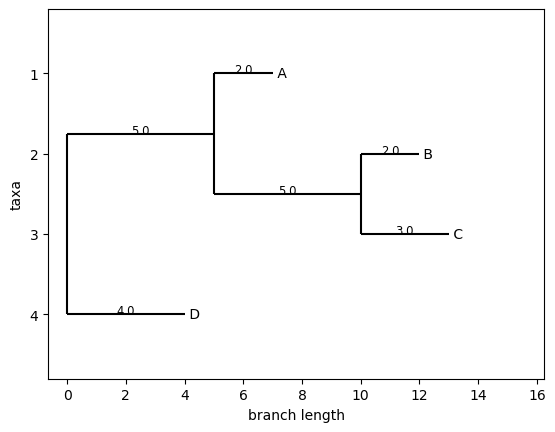

In [8]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'
from Bio import Phylo
from ete3 import Tree #, TreeStyle
from io import StringIO

# Lire l'arbre à partir de la chaîne Newick
newick_tree = '((A:2,(B:2,C:3):5):5,D:4);'
tree = Phylo.read(StringIO(newick_tree), 'newick')

# Afficher l'arbre 
Phylo.draw(tree, branch_labels=lambda c: c.branch_length)

**Exercice 5 :** Reécrivez l'arbre suivant au format Newick puis afficher-le. Les nombres correspondent aux longueurs des branches :
![](input/tree.png)

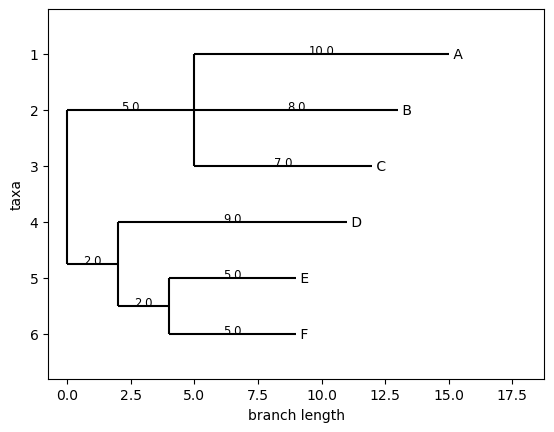

In [9]:
newick_tree2 = '((A:10, B:8, C:7):5, (D:9, (E:5, F:5):2):2);'

tree2 = Phylo.read(StringIO(newick_tree2), 'newick')

# Afficher l'arbre 
Phylo.draw(tree2, branch_labels=lambda c: c.branch_length)

**Exercice 6 :** Expliquer la relation de parenté entre $A$, $B$ et $C$ ? Qu'elles sont les hypothèses qui pourraient expliquer ce type d'embranchement dans un arbre ? Donner une réponse détaillée.

Réponse : 

A, B et C sont tous les trois des feuilles de l'arbre qui ont une racine commune. Cela signifie qu'ils ont une parenté étroite entre eux et qu'ils ont probablement divergé récemment. Cependant, il n'y a pas de relation de parenté directe entre les nœuds A, B et C. Ils sont simplement des frères et sœurs, ou des « cousins », dans l'arbre généalogique.


L'embranchement de ce type dans un arbre phylogénétique peut être expliqué par plusieurs hypothèses :
- L'hypothèse du gène universel : Cette hypothese stipule que tous les organismes vivants partagent un ensemble de gènes communs impliqués dans des fonctions cellulaires fondamentales, telles que la réplication de l'ADN et la traduction de l'ARN en protéines.
- L'hypothèse de la sélection naturelle : les organismes qui ont des caractéristiques avantageuses pour leur survie et leur reproduction ont plus de chances de se transmettre ces caractéristiques à leur descendance, créant ainsi de nouveaux groupes d'organismes avec des caractéristiques similaires.
- Hypothèse de l'hérédité parent-enfant : certains traits ou caractéristiques peuvent être transmis de manière héritée de parents à leurs descendants, créant ainsi des groupes d'organismes avec des traits similaires.
- Hypothèse de la séparation géographique : la formation de nouvelles espèces résulte de la séparation géographique de populations d'organismes, qui peuvent ensuite subir des pressions de sélection différentes dans leur nouvel environnement et évoluer indépendamment les unes des autres.

### UPGMA

L'algorithme UPGMA se base sur la matrice de distance entre les séquences. À chaque itération, les séquences avec la distance la plus faible sont regroupées puis une nouvelle matrice de distance est calculée avec le nouveau groupe. Cette étape est répétée jusqu'à n'avoir plus qu'un seul groupe. Par exemple, avec la matrice de distance entre les séquences $A$, $B$, $C$ et $D$ suivante :

|   &nbsp;   | A | B | C | D |
|   -   | - | - | - | - |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |
| **D** | 2 | 4 | 8 | &nbsp; |

Les séquences $A$ et $D$ sont les plus proches ($distance(A,D)=2$). On les regroupe et on met à jour la matrice :

|   &nbsp;   | (A, D) | B | C |
|   -   | - | - | - |
| **(A, D)** | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |

On regroupe maintenant $(A,D)$ et $B$ ($distance((A,D),B) = 4$) :

|   &nbsp;   | ((A, D), B) | C |
|   -   | - | - |
| **((A, D), B)** | &nbsp; | &nbsp; |
| **C** | 8 | &nbsp; |

Important : les nouvelles distances sont calculées en moyennant les distances entre les membres du nouveau groupe et des groupes non modifiés pondéré par le nombre d'UTOs dans chaque groupe. Avec $i$ et $j$ les deux membres du groupe nouvellement formé et k les groupes restant : $d_{ij,k} = \frac{n_id_{ik}}{n_i + n_j}+ \frac{n_jd_{jk}}{n_i + n_j}$. Par exemple avec la distance entre $((A, D), B)$ et $C$:

$distance(((A, D), B), C) = (distance((A, D), C)*2 + distance(B, C)) \mathbin{/} 3 = (8*2 + 8) \mathbin{/} 3 = 8 $.

L'arbre final écrit dans le format Newick est : $((A, D), B), C);$ 

Et avec les distances : $((A:1, D:1):1, B:2):2, C:4);$ 

**Exercice 7 :** Implémenter une version d'UPGMA qui calcule l'arbre au format Newick **avec les distances** puis appliquer votre algorithme aux données. 

In [10]:
def is_int(n):
    try:
        float_n = float(n)
        int_n = int(float_n)
    except ValueError:
        return False
    else:
        return float_n == int_n

def is_float(n):
    try:
        float_n = float(n)
    except ValueError:
        return False
    else:
        return True

In [11]:
def extraitPropriete(nom):
    tmp = nom.split(",")
    tmp2 = []
    res = []
    tmp3 = []
    tmp4 = []
    for i in range(len(tmp)):
        tmp2.append(tmp[i].split("("))
    for i in range(len(tmp2)):
        for j in range(len(tmp2[i])):  
            tmp3.append(tmp2[i][j].split(")"))
    for i in range(len(tmp3)):
        for j in range(len(tmp3[i])):  
            tmp4.append(tmp3[i][j].split(":"))
    for i in range(len(tmp4)):
        for j in range(len(tmp4[i])): 
            if tmp4[i][j] != '' :
                res.append(tmp4[i][j])
    dernier = float(res[len(res)-1])
    return res, dernier

def extraitPropriete2(nom):
    tmp = nom.split(",")
    tmp2 = []
    res = []
    tmp3 = []
    tmp4 = []
    for i in range(len(tmp)):
        tmp2.append(tmp[i].split("("))
    for i in range(len(tmp2)):
        for j in range(len(tmp2[i])):  
            tmp3.append(tmp2[i][j].split(")"))
    for i in range(len(tmp3)):
        for j in range(len(tmp3[i])):  
            tmp4.append(tmp3[i][j].split(":"))
    for i in range(len(tmp4)):
        for j in range(len(tmp4[i])): 
            if tmp4[i][j] != '' :
                res.append(tmp4[i][j])
    return res

def extraitNoms(lst):
    tmp = []
    res = []
    for i in range (len(lst)):
        tmp.append(lst[i].split(":"))
    for i in range(len(tmp)):
        for j in range(len(tmp[i])):  
            if tmp[i][j] != '' and not(is_int(tmp[i][j])) and not(is_float(tmp[i][j])):
                res.append(tmp[i][j])
    return res

L'arbre final écrit dans le format Newick est :  ('(((A:1.0,D:1.0):1.0,B:2.0):2.0,C:4.0)', '(((A,D),B),C)')
L'arbre final écrit dans le format Newick est :  (((((((African:0.005,Wild:0.005):0.003,Felis:0.008):0.043,Chinese:0.051):0.132,((American:0.027,Puma:0.027):0.015,Cheetah:0.042):0.141):0.056,((Lion:0.039,Leopard:0.039):0.02,Tiger:0.059):0.138):0.194,((Sabertooth:0.069,Homotherium:0.069):0.084,(Spotted:0.063,Striped:0.063):0.09):0.242):0.264,(((Brown:0.035,Cave:0.035):0.022,Black:0.057):0.139,(Dog:0.0,Wolf:0.0):0.196):0.31)


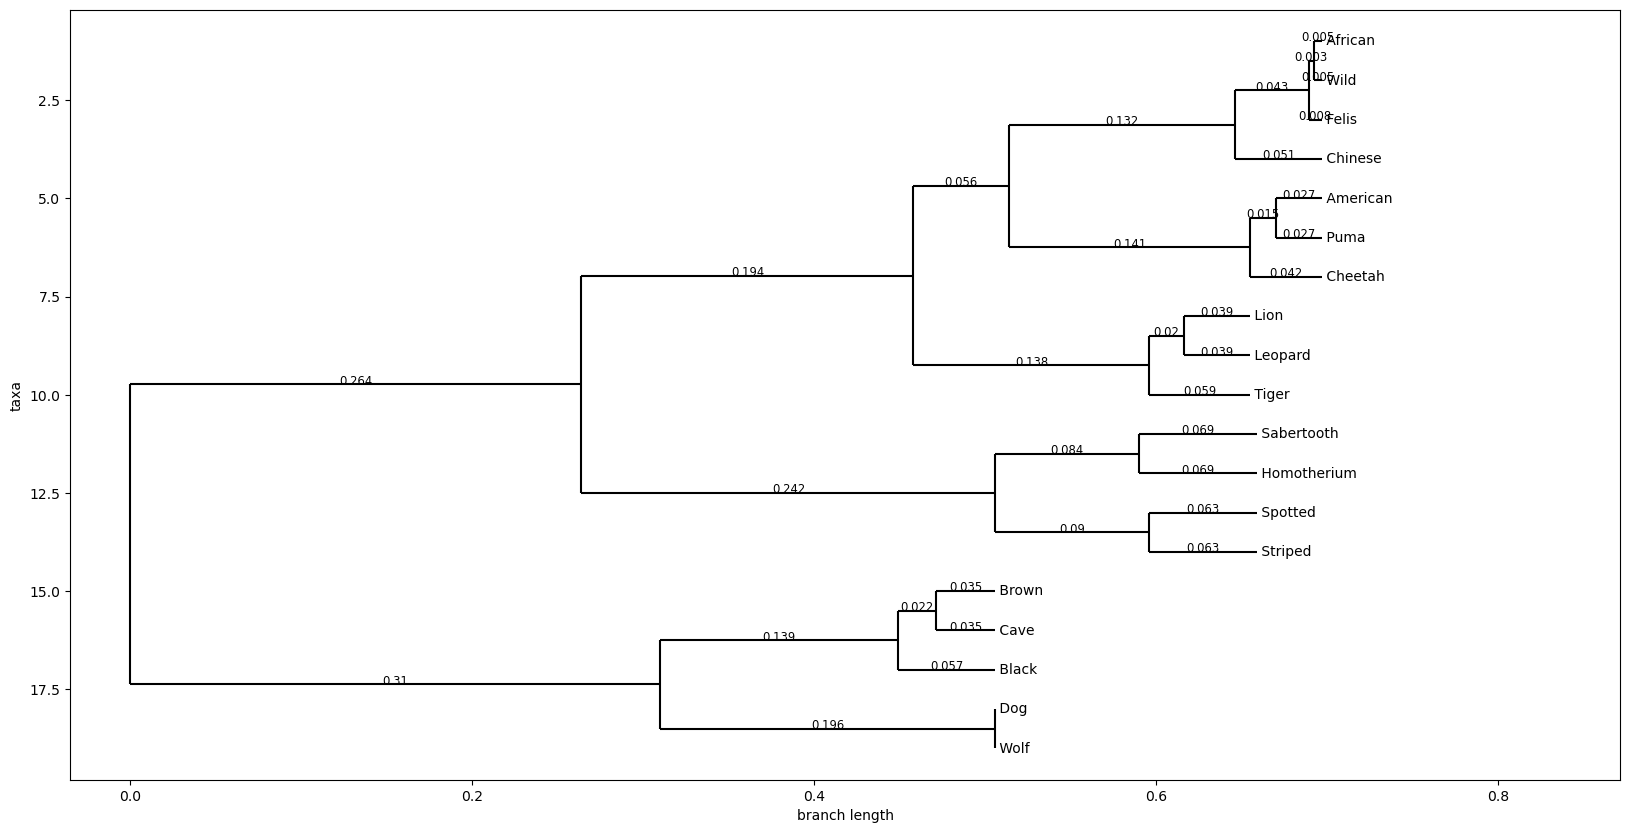

In [12]:
def upgma(matrix, noms):
    # Initialiser les groupes avec chaque nom
    groupes = [[nom] for nom in noms]
    groupeSansPoid = [[nom] for nom in noms]
    # Transformer la matrice en tableau numpy
    matrice = np.array(matrix) 
    
    # Boucle jusqu'à ce qu'il n'y ait plus qu'un seul groupe
    while(len(groupes) > 1): 
        
        # Initialiser les variables pour trouver le minimum dans la matrice
        x, y = 0, 0
        minimum = 100000
        
        # Boucle pour trouver les indices du minimum dans la matrice
        for i in range (len(matrice)):
            for j in range (i+1, len(matrice)):
                if matrice[i][j] < minimum and i != j:
                    minimum = matrice[i][j]
                    x = i
                    y = j
        # Déterminer le poid de chaque nom           
        poid = minimum / 2
        tmp = ""
        resSansPoind = ""
        
        # Si le premier nom dans le premier groupe est un nom de groupe (entouré de parenthèses)
        if("(" in groupes[x][0]):
            if "(" in groupes[y][0]:
                TMP1, n1 = extraitPropriete(groupes[x][0])
                aajouter = poid - n1
                TMP2, n2 = extraitPropriete(groupes[y][0])
                aajouter2 = poid - n2
                tmp = "(" + groupes[x][0] + ":" + str(round(abs(aajouter),3)) + "," + groupes[y][0] + ":" + str(round(abs(aajouter2),3)) + ")"
            else:
                TMP1, n1 = extraitPropriete(groupes[x][0])
                aajouter = poid - n1
                tmp = "(" + groupes[x][0] + ":" + str(round(abs(aajouter),3)) + "," + groupes[y][0] + ":" + str(round(abs(poid),3)) + ")"
        # Si le premier nom dans le premier groupe est un nom simple
        else :
            tmp = "(" + groupes[x][0] + ":" + str(round(abs(poid),3)) + "," + groupes[y][0] + ":" + str(round(abs(poid),3)) + ")"
        resSansPoind = "(" + groupeSansPoid[x][0] + "," + groupeSansPoid[y][0] + ")"
        tmp2 = [tmp]
        # Supprimer les groupes x et y
        groupes.remove(groupes[y])
        groupes.remove(groupes[x])
        # Insérer le nouveau groupe formé par x et y en première position
        groupes.insert(0, tmp2)
        
    
        groupeSansPoid.remove(groupeSansPoid[y])
        groupeSansPoid.remove(groupeSansPoid[x])
        groupeSansPoid.insert(0, [resSansPoind])
        
        # Initialiser une nouvelle matrice
        new_matrice = np.zeros((len(groupes), len(groupes)))
        
        # Boucle pour remplir la nouvelle matrice
        for i in range(len(groupes)):
            for j in range(i+1, len(groupes)):
                # Extrait les propriétés du groupe j
                if("(" in groupes[j][0]) :
                    TMP2, n2 = extraitPropriete(groupes[j][0])
                    lst2 = extraitNoms(TMP2)
                else:
                    # Si ce n'est pas un groupe, on met le nom dans une liste
                    lst2 = [groupes[j][0]]
                # Extrait les propriétés du groupe i
                if("(" in groupes[i][0]):
                    TMP1, n1 = extraitPropriete(groupes[i][0])
                    lst1 = extraitNoms(TMP1)
                else:
                    # Si ce n'est pas un groupe, on met le nom dans une liste
                    lst1 = [groupes[i][0]]
                # Nombre d'éléments dans le premier groupe
                n = len(lst1)
                # Nombre d'éléments dans le deuxième groupe
                m = len(lst2)
                tmpRes = 0

                # Boucle pour ajouter les scores de chaque nom dans les deux groupes
                for k in range(n):
                    indiceLettre1 = noms.index(lst1[k])
                    for t in range(m):
                        indiceLettre2 = noms.index(lst2[t])
                        tmpRes = tmpRes + matrix[indiceLettre1][indiceLettre2] 
                # Calcule la moyenne des scores
                new_matrice[i][j] = tmpRes/(n)
                new_matrice[j][i] = new_matrice[i][j]
        matrice = new_matrice
    return groupes[0][0], groupeSansPoid[0][0]
labels = ['A', 'B', 'C', 'D']
matrix = [[0, 4, 8, 2], [4, 0, 8, 4], [8, 8, 0, 8], [2, 4, 8, 0]]
print("L'arbre final écrit dans le format Newick est : ", upgma(matrix, labels))
labels = ListFromDict2(seq_cat)
matrix = Matrice_Distance
UPGMA_Seq = upgma(matrix, labels)
print("L'arbre final écrit dans le format Newick est : ", UPGMA_Seq[0])
t = UPGMA_Seq[0] + ";";
upgma_tree = Phylo.read(StringIO(t), 'newick')
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))
Phylo.draw(upgma_tree,axes=ax, branch_labels=lambda c: c.branch_length)

**Exercice 8 :** Quelles sont les hypothèses faites par UPGMA ? Semblent-elles respectées dans le cas présent ?

Réponse : 
Les hypothèses faites par UPGMA sont que toutes les espèces évoluent au même rythme et sont toutes contemporaines.
Dans l'arbre résultat que nous obtenons, nous observons que la distance racine-feuille est égale pour toutes les feuilles. Et les espèces n'ayant pas vécu à la même époque se retrouvent proches les unes des autres (la temporatlité n'est pas réspectée).

Donc l'arbre semble bien respecter l'hypothese établie par UPGMA.

----
## Enracinement de l'arbre

Après avoir utilisé UPGMA pour réaliser votre arbre, l'enracinement s'est normalement fait au poids moyen. 

**Exercice 9 :** Quelle autre méthode est-il possible d'utiliser pour enraciner un arbre ? Pouvez-vous l'utilisez ici ? Si oui, afficher le nouvel arbre.

**Réponse :** 
Une autre méthode possible pour enraciner un arbre consiste à utiliser un groupe extérieur. Cette méthode implique d'ajouter un groupe extérieur à l'arbre et de l'utiliser comme point de référence pour enraciner l'arbre. Le groupe extérieur choisi doit être étroitement lié au groupe étudié mais considéré comme plus primitif ou ancestral.

Dans le cas de notre exemple, nous pouvons utiliser le groupe "Chien, Loup ainsi que les ours" comme outgroup pour illustrer cette méthode. Étant donné que ces espèces sont déjà regroupées à part dans l'arbre, l'ajout de l'outgroup n'entraîne pas de modification majeure de l'arbre, qui reste identique à celui obtenu par la méthode UPGMA.

----
## Neighbor-joining

Le neighbor-joining est un autre algorithme permettant de calculer un arbre phylogénique à partir d'une matrice de distance. Il a l'avantage de faire moins d'hypothèse qu'UPGMA sur les données (elles ne sont plus forcément ultramétrique) et il donne donc de meilleurs arbres dans presque tout les cas. Vous trouverez un example d'application de cet algorithme [ici](http://www.evolution-textbook.org/content/free/tables/Ch_27/T11_EVOW_Ch27.pdf).

**Exercice 10 :** Implémenter l'algorithme du neighbor-joining, appliquer-le aux données puis enraciner l'arbre.

In [13]:
def enleve_parenthese(mot):
    res = ""
    tmp = 0
    i = 1
    while i < len(mot)-1:
        res += mot[i] 
        i  = i+1
    return res

def separe_mot(mot):
    res = []
    i = 0
    index = 0
    while i < len(mot):
        if mot[i] != ',':
            if mot[i] != '(':
                res.append([])
                j = i
                while j < len(mot) and mot[j] != ',' :
                    res[index].append(mot[j])
                    j = j + 1
                t = "".join(res[index])
                res[index] = t
                index = index + 1
                i = i + j
            else:
                res.append([])
                j = i+1
                tmp = 1
                res[index].append(mot[i])
                while tmp > 0 :
                    if mot[j] == '(':
                        tmp = tmp + 1
                    elif mot[j] == ')':
                        tmp = tmp - 1
                    res[index].append(mot[j])
                    j = j + 1
                t = "".join(res[index])
                res[index] = t
                index = index + 1
                i = i + j
        else : 
            i = i + 1
    return res            
print(separe_mot('((A:0.0174,B:0.0174),C:0.0174),F:0.0174'))      

['((A:0.0174,B:0.0174),C:0.0174)', 'F:0.0174']


In [14]:
def Neighbor_Joining(matrix, noms):
    # Step 1:
    groupes = [[nom] for nom in noms] #Groupe avec les poid
    groupes_e = [[nom] for nom in noms]
    groupes_e2 = [[nom] for nom in noms]# Groupe sans les poids
    matrice = np.array(matrix)
    # Boucle jusqu'à ce qu'il n'y ait plus qu'un seul groupe
    while(len(groupes) > 1): 
        S = []
        n = len(groupes)
        if n-2 > 0:
            for i in range (n):
                res = 0
                for j in range (n):
                    res = res + matrice[i][j]
                S.append(res/(n-2))
            # Step 2:
            new_matrice = np.zeros((n, n))
            for i in range(n):
                for j in range (n):
                    if i == j :
                        new_matrice[i][j] = 0
                    else :
                        new_matrice[i][j] = matrice[i][j] - S[i] - S[j]

            #Step 3:
            x, y = 0, 0
            minimum = 100000

        # Boucle pour trouver les indices du minimum dans la matrice
        for i in range (len(new_matrice)):
            for j in range (i+1, len(new_matrice)):
                if new_matrice[i][j] < minimum and i != j:
                    minimum = new_matrice[i][j]
                    x = i
                    y = j
        if n-2 > 0:
            # Déterminer le poid de chaque nom           
            poid1 = (matrice[x][y]/2) + (S[x] - S[y])/2
            poid2 = (matrice[x][y]/2) + (S[y] - S[x])/2

            U = "(" + groupes[x][0] + ":" + str(round(poid1,4)) + "," + groupes[y][0] + ":" + str(round(poid2,4)) + ")"
            V = "(" + groupes_e[x][0] + "," + groupes_e[y][0] + ")"
            # Supprimer les groupes x et y
            groupes.remove(groupes[y])
            groupes.remove(groupes[x])
            groupes_e.remove(groupes_e[y])
            groupes_e.remove(groupes_e[x])
            # Insérer le nouveau groupe formé par x et y en première position
            groupes.insert(0, [U])
            groupes_e.insert(0, [V])
            # Initialiser une nouvelle matrice
            new_matrice2 = np.zeros((len(groupes_e), len(groupes_e)))
            # Boucle pour remplir la nouvelle matrice
            for i in range(len(groupes_e)):
                if '(' in groupes_e[i][0] and groupes_e[i] == [V]:
                    mot = enleve_parenthese(groupes_e[i][0])
                    lst = separe_mot(mot)
                    mot1 = [lst[0]]
                    mot2 = [lst[1]]
                    id1 = groupes_e2.index(mot1)
                    id2 = groupes_e2.index(mot2)
                    for j in range(i+1, len(groupes_e)):
                        idTmp = groupes_e2.index(groupes_e[j])
                        new_matrice2[i][j] = (matrice[id1][idTmp] + matrice[id2][idTmp] - matrice[id1][id2]) / 2
                        new_matrice2[j][i] = (matrice[id1][idTmp] + matrice[id2][idTmp] - matrice[id1][id2]) / 2
                else:
                    for j in range(i+1, len(groupes_e)):
                        id1 = groupes_e2.index(groupes_e[i])
                        id2 = groupes_e2.index(groupes_e[j])
                        new_matrice2[i][j] = matrice[id1][id2]
                        new_matrice2[j][i] = matrice[id1][id2]
            groupes_e2.remove(groupes_e2[y])
            groupes_e2.remove(groupes_e2[x])
            groupes_e2.insert(0, [V])
            matrice = new_matrice2
        else:
            U = "(" + groupes[0][0] + "," + groupes[1][0] + ":" + str(round(matrice[0][1],4)) + ")"
            V = "(" + groupes_e[0][0] + "," + groupes_e[1][0] + ")"
            # Supprimer les groupes x et y
            groupes.remove(groupes[1])
            groupes.remove(groupes[0])
            groupes_e.remove(groupes_e[1])
            groupes_e.remove(groupes_e[0])
            groupes_e2.remove(groupes_e2[1])
            groupes_e2.remove(groupes_e2[0])
            # Insérer le nouveau groupe formé par x et y en première position
            groupes.insert(0, [U])
            groupes_e.insert(0, [V])
            groupes_e2.insert(0, [V])
    return groupes[0][0], groupes_e2[0][0]
        
        
labels = ['A', 'B', 'C', 'D', 'E', 'F']
matrix = [[0, 5, 4, 7, 6, 8], [5, 0, 7, 10, 9, 11], [4, 7, 0, 7, 6, 8], [7, 10, 7, 0, 5, 9], [6, 9, 6, 5, 0, 8], [8, 11, 8, 9, 8, 0]] 
Neighbor_Joining(matrix, labels)


('(((((A:1.0,B:4.0):1.0,C:2.0):1.0,F:5.0):1.0,D:3.0),E:2.0)',
 '(((((A,B),C),F),D),E)')

L'arbre final écrit dans le format Newick avec NJ est :  (((((((Felis:0.0091,Wild:0.0051):0.0026,African:0.0045):0.0457,Chinese:0.0485):0.006,((American:0.0203,Puma:0.0343):0.0229,Cheetah:0.0332):0.0177):0.0054,(((Sabertooth:0.0551,Homotherium:0.0827):0.0093,(Spotted:0.0573,Striped:0.0685):0.0122):0.006,(((Brown:0.045,Cave:0.0251):0.0231,Black:0.0553):0.0378,(Dog:0.0,Wolf:0.0):0.1063):0.0197):0.0174):0.0048,(Lion:0.0363,Leopard:0.0416):0.0251),Tiger:0.0541)


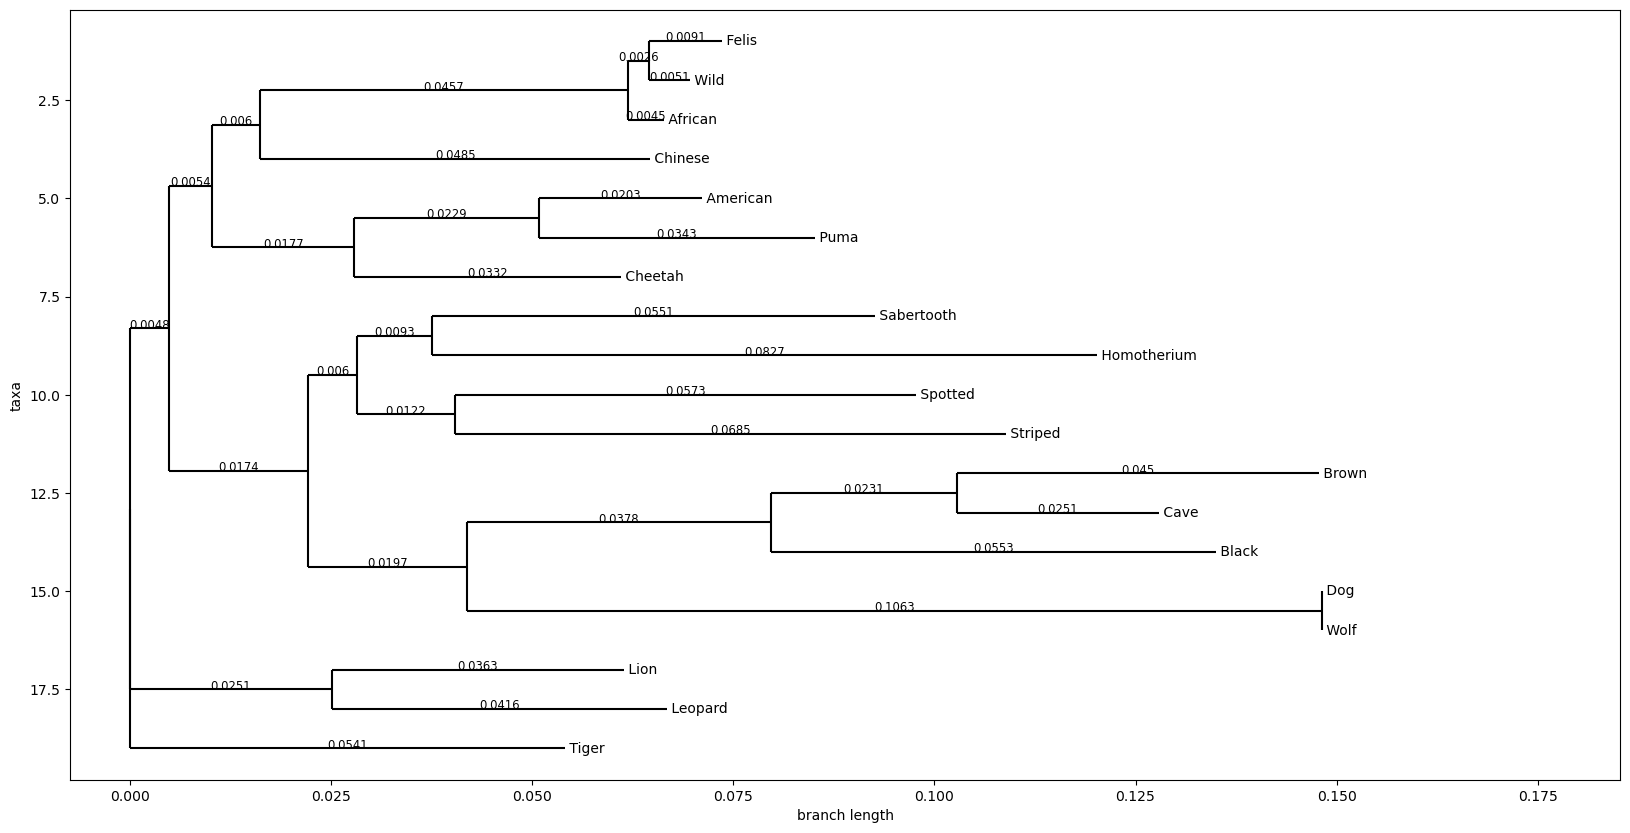

In [15]:
labels = ListFromDict2(seq_cat)
matrix = Matrice_Distance
NJ_Seq = Neighbor_Joining(matrix, labels)
print("L'arbre final écrit dans le format Newick avec NJ est : ", NJ_Seq[0])
t2 = NJ_Seq[0] + ";";
nj_tree = Phylo.read(StringIO(t2), 'newick')
fig, ax = plt.subplots(figsize=(20, 10))
Phylo.draw(nj_tree,axes=ax, branch_labels=lambda c: c.branch_length)

----
## Bootstrap

Le bootstrap est une méthode permettant de calculer la robustesse des branches d'un arbre. Il sagit de recréer un jeu de données artificiel en tirant n positions dans l'alignement des séquences avec remise, n étant la longueur de l'alignement. On recréer un arbre à partir de ces nouvelles données puis on le compare avec l'arbre obtenu avec les données réelles. Si une branche de l'arbre réelle est présente dans l'arbre artificiel, son bootstrap augmente de 1. On répètera la procédure 100 fois afin d'avoir un score sur 100 pour chaque branche.

**Exercice 11 :** Calculer le bootstrap des branches des arbres obtenus avec UPGMA et neighbor-joining.

In [16]:
def cleanString(Str):
    patternDigit = r'[0-9]'
    patternSepar = r'[: .]'
    new_string = re.sub(patternDigit, '', Str)
    new_string = re.sub(patternSepar, '', new_string)
    return new_string

def splitTree2(tree):
    res = []
    return splitTree2Bis(tree, res)

def splitTree2Bis(tree, res):
    parenthese = 0
    parenthese2 = 0
    part1 = ""
    part2 = ""
    dans1 = True
    dans2 = False
   
    if(tree == "" or "(" not in tree ):
        return res
    else:
        for i in range(1, len(tree)):
            
            if(tree[i] == "("):
                parenthese += 1
            elif(tree[i] == ")"):
                parenthese -= 1
            if ((not dans1) and (tree[i] == ",") ):
                dans2 = True
                
            if(dans1):
                part1 += tree[i]
            if(dans2):
                part2 += tree[i]
                
            if(parenthese == 0):
                dans1 = False
        
        if(part1 != "" and len(part1) > 1):
            res.append(part1)
            splitTree2Bis(part1, res)
        if(part2 != "" and len(part2) > 1):
            if(part2[0] == ","):
                part2 = part2[1:-1]
            res.append(part2)
            splitTree2Bis(part2, res)
        return res
    
def cleanSplit(BranchTab):
    res = []
    for i in BranchTab:
        if("(" in i):
            res.append(i)
    return res

def BranchIsTwoElem(branch):
    words_pattern = '[a-z]+'
    x = re.findall(words_pattern, branch, flags=re.IGNORECASE)
    if(len(x) == 2):
        return True
    
def BranchAndReverse(branch):
    res = []
    words_pattern = '[a-z]+'
    x = re.findall(words_pattern, branch, flags=re.IGNORECASE)
    word =  "("+x[0]+","+x[1]+ ")"
    res.append(word)
    word2 = "("+x[1]+","+x[0]+ ")"
    res.append(word2)
    return res

# take second element for sort
def takeSecond(elem):
    return elem[1]

In [17]:
import random 
import re
def Bootstrap(dic, iteration, Seq, Algo):
    Branches1 = splitTree2(cleanString(Seq[0])) 
    Branches1 = cleanSplit(Branches1)
    tabPoids = [0 for i in range(len(Branches1))]
    tabBranches = [];
    seq = Seq[1];
    print("      Bootstrap pour "+str(iteration)+" iterations \n")
    for i in Branches1:
        tmp = extraitPropriete2(i);
        test = extraitNoms(tmp);
        tabBranches.append((i, len(test)));
    tabBranches.sort(key=takeSecond, reverse=True);
    b = map(lambda x: x[0], tabBranches)
    Branches1 = list(b)
    print("Les branches sont : \n")
    for i in Branches1:
        print(i)
    
    res = bootstrap_bis(dic, iteration, Branches1, Algo, tabPoids);
    ind = 0
    for i in Branches1:
        new_seq = i + ":" + str(res[ind]*100/iteration)
        seq = seq.replace(i, new_seq)
        ind = ind + 1
    return seq

def bootstrap_bis(dic, iteration, Branches, AlgoUsed, tabPoids):
    if(iteration != 0):
        sequences = ListFromDict(dic)
        cle = ListFromDict2(dic)

        n = len(sequences)
        m = len(sequences[0])

        arbreAComparer = ""
        res = ["" for i in range(n)]

        #1er Bootstrap
        for i in range(m):
            integer = random.randint(0,m-1)
            for j in range(n):
                res[j] += sequences[j][integer]
        dic = {}

        for i in range(len(res)):
            dic[cle[i]] = res[i]
        Matrice_Distance2 = matrices_distance(dic)

        if(AlgoUsed == "UPGMA"):
            arbreAComparer = upgma(Matrice_Distance2, cle)[0]
        elif(AlgoUsed == "NJ"):
            arbreAComparer = Neighbor_Joining(Matrice_Distance2, cle)[0]
            
        arbreAComparer = cleanString(arbreAComparer)
        monArbre = Tree(arbreAComparer + ";")
        
        for i in range(len(Branches)):
            maBranche = Tree(Branches[i] + ";")
            if(maBranche.compare(monArbre)['ref_edges_in_source'] == 1.0):
                tabPoids[i] += 1
            
            #ici on utilise arbreAComparer et Branches[i] car on ne les veut pas les avoir formatter en Tree
            if(BranchIsTwoElem(Branches[i])):
                BrancheAComparer = BranchAndReverse(Branches[i])
                if(BrancheAComparer[0] in arbreAComparer or BrancheAComparer[1] in arbreAComparer):
                    tabPoids[i] += 1
        print("Nombre d'iterations restantes : "+str(iteration-1))
        return bootstrap_bis(dic, iteration-1, Branches, AlgoUsed, tabPoids)
    else:
        return tabPoids

In [18]:
Bootstrap(seq_cat, 30, UPGMA_Seq, "UPGMA")

      Bootstrap pour 30 iterations 

Les branches sont : 

((((((African,Wild),Felis),Chinese),((American,Puma),Cheetah)),((Lion,Leopard),Tiger)),((Sabertooth,Homotherium),(Spotted,Striped)))
(((((African,Wild),Felis),Chinese),((American,Puma),Cheetah)),((Lion,Leopard),Tiger))
((((African,Wild),Felis),Chinese),((American,Puma),Cheetah))
(((Brown,Cave),Black),(Dog,Wolf))
(((African,Wild),Felis),Chinese)
((Sabertooth,Homotherium),(Spotted,Striped))
((African,Wild),Felis)
((American,Puma),Cheetah)
((Lion,Leopard),Tiger)
((Brown,Cave),Black)
(African,Wild)
(American,Puma)
(Lion,Leopard)
(Sabertooth,Homotherium)
(Spotted,Striped)
(Brown,Cave)
(Dog,Wolf)
Nombre d'iterations restantes : 29
Nombre d'iterations restantes : 28
Nombre d'iterations restantes : 27
Nombre d'iterations restantes : 26
Nombre d'iterations restantes : 25
Nombre d'iterations restantes : 24
Nombre d'iterations restantes : 23
Nombre d'iterations restantes : 22
Nombre d'iterations restantes : 21
Nombre d'iterations restante

'(((((((African,Wild):0.0,Felis):0.0,Chinese):0.0,((American,Puma):96.66666666666667,Cheetah):100.0):0.0,((Lion,Leopard):60.0,Tiger):86.66666666666667):0.0,((Sabertooth,Homotherium):6.666666666666667,(Spotted,Striped):0.0):0.0):0.0,(((Brown,Cave):36.666666666666664,Black):76.66666666666667,(Dog,Wolf):100.0):40.0)'

In [19]:
Bootstrap(seq_cat, 30, NJ_Seq, "NJ")

      Bootstrap pour 30 iterations 

Les branches sont : 

((((((Felis,Wild),African),Chinese),((American,Puma),Cheetah)),(((Sabertooth,Homotherium),(Spotted,Striped)),(((Brown,Cave),Black),(Dog,Wolf)))),(Lion,Leopard))
(((((Felis,Wild),African),Chinese),((American,Puma),Cheetah)),(((Sabertooth,Homotherium),(Spotted,Striped)),(((Brown,Cave),Black),(Dog,Wolf))))
(((Sabertooth,Homotherium),(Spotted,Striped)),(((Brown,Cave),Black),(Dog,Wolf)))
((((Felis,Wild),African),Chinese),((American,Puma),Cheetah))
(((Brown,Cave),Black),(Dog,Wolf))
(((Felis,Wild),African),Chinese)
((Sabertooth,Homotherium),(Spotted,Striped))
((Felis,Wild),African)
((American,Puma),Cheetah)
((Brown,Cave),Black)
(Felis,Wild)
(American,Puma)
(Sabertooth,Homotherium)
(Spotted,Striped)
(Brown,Cave)
(Dog,Wolf)
(Lion,Leopard)
Nombre d'iterations restantes : 29
Nombre d'iterations restantes : 28
Nombre d'iterations restantes : 27
Nombre d'iterations restantes : 26
Nombre d'iterations restantes : 25
Nombre d'iterations restan

'(((((((Felis,Wild):10.0,African):10.0,Chinese):10.0,((American,Puma):70.0,Cheetah):70.0):3.3333333333333335,(((Sabertooth,Homotherium):13.333333333333334,(Spotted,Striped):10.0):10.0,(((Brown,Cave):56.666666666666664,Black):70.0,(Dog,Wolf):100.0):13.333333333333334):0.0):0.0,(Lion,Leopard):86.66666666666667):0.0,Tiger)'

----
## Conclusion

**Exercice 12 :** Quelles sont vos conclusions par rapport à l'arbre phylogénique de _smilodon_, _homotherium_ et _M. trumani_ ? Comparer les deux méthodes. Comment expliquer les caractéristiques morphologiques similaires entre ces trois espèces ? Une réponse détaillée est attendue.

Réponse :
Les deux méthodes de construction d'arbres phylogénétiques, UPGMA et Neighbor Joining, ont abouti à des arbres  phylogénétiques assez similaires avec des différences mineures notamment dans la longueur des branches. On peut remarquer des différences pour les espèces Smilodon, Homotherium et M. trumani entre ces arbres qui peuvent être expliquées par les méthodes utilisées pour les construire.

L'arbre UPGMA est basé sur la distance génétique entre les espèces, tandis que l'arbre Neighbor Joining est basé sur une méthode de regroupement itérative qui prend en compte les distances génétiques et les relations entre les espèces. Par conséquent, l'arbre Neighbor Joining peut être considéré comme étant plus précis et robuste.

Les résultats indiquent que Smilodon, Homotherium et M. trumani appartiennent tous à la famille des félins, bien qu'il y ait quelques variations dans leur position exacte dans l'arbre. Selon les deux méthodes, Homotherium et Smilodon forment un seul groupe, indiquant qu'ils partagent un ancêtre commun plus récent avec l'autre qu'avec M. trumani. Cette relation est également soutenue par les valeurs de bootstrap pour la branche Homotherium-Smilodon dans l'arbre NJ.

Malgré tout, ces espèces partagent des caractéristiques morphologiques similaires, notamment des canines allongées et des griffes rétractables, qui ont peut-être évolué de manière indépendante en réponse à des pressions environnementales. Cela peut s'expliquer par des facteurs évolutifs, énoncés précedemment, tels que l'hypothèse du gène universel, de la sélection naturelle, de l'hérédité parent-enfant ou encore celle de la séparation géographique.

En conclusion, bien que les deux méthodes aient produit des arbres différents, elles ont par conséquent révélées une relation proche entre Homotherium et Smilodon, ce qui indique une histoire évolutive partagée entre ces deux espèces.